In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

# Import kagglehub
import kagglehub

# Ensure NLTK resources are downloaded within the Kaggle Notebook environment.
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [4]:
# Download the dataset using kagglehub
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")
print("Path to dataset files:", path)

# Construct the full file path.
file_path = f"{path}/spam.csv"

try:
    df = pd.read_csv(file_path, encoding='latin-1')
    print("\nDataset loaded successfully!")
except Exception as e:
    print(f"\nError loading dataset with 'latin-1' encoding: {e}")
    try: # Fallback to common alternative if initial load fails
        df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'], encoding='latin-1')
        print("Dataset loaded with tab separator and custom headers.")
    except Exception as e_fallback:
        print(f"Error with fallback loading: {e_fallback}")
        # If both fail, you might need to inspect the downloaded files
        # import os
        # print(os.listdir(path))

print(df.head())
print(df.info())
print(df.columns)

Path to dataset files: /kaggle/input/sms-spam-collection-dataset

Dataset loaded successfully!
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3  


DataFrame after cleaning columns:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)

Label mapping applied:
   label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

Missing values per column:
label      0
message    0
dtype: int64
No missing values found!

Distribution of Ham (0) vs. Spam (1):
label
0    4825
1     747
Name: count, dtype: int64


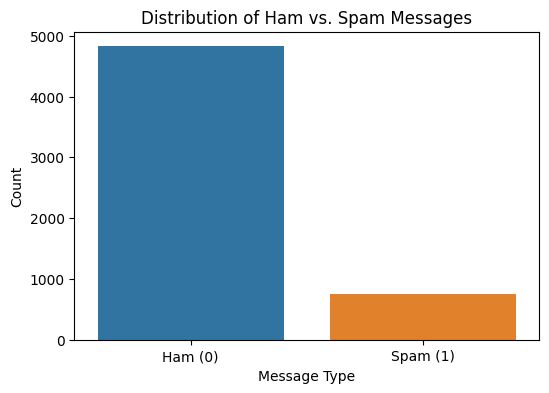


DataFrame with message length:
   label                                            message  message_length
0      0  Go until jurong point, crazy.. Available only ...             111
1      0                      Ok lar... Joking wif u oni...              29
2      1  Free entry in 2 a wkly comp to win FA Cup fina...             155
3      0  U dun say so early hor... U c already then say...              49
4      0  Nah I don't think he goes to usf, he lives aro...              61


In [5]:
# Drop unnecessary columns if they exist (common in 'spam.csv')
if 'Unnamed: 2' in df.columns:
    df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

# Rename columns for clarity
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

print("\nDataFrame after cleaning columns:")
print(df.head())
print(df.shape)

# Convert labels to numerical format (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

print("\nLabel mapping applied:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())
if df.isnull().sum().sum() == 0:
    print("No missing values found!")

# Check class distribution
print("\nDistribution of Ham (0) vs. Spam (1):")
print(df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham vs. Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham (0)', 'Spam (1)'])
plt.show()

# Create a new feature: message length (this is where df['message_length'] is defined)
df['message_length'] = df['message'].apply(len)

print("\nDataFrame with message length:")
print(df.head())

In [6]:
# ----------------------------------------------------
# New Feature Engineering Part
# ----------------------------------------------------

# Feature 1: Number of words
def count_words(text):
    return len(nltk.word_tokenize(text))

df['num_words'] = df['message'].apply(count_words)
print("\nAdded 'num_words' column:")
print(df[['message', 'num_words']].head())


# Feature 2: Number of sentences
def count_sentences(text):
    # Using sent_tokenize from NLTK for more accurate sentence splitting
    return len(nltk.sent_tokenize(text))

# You already downloaded punkt above, but including here for completeness
# nltk.download('punkt')

df['num_sentences'] = df['message'].apply(count_sentences)
print("\nAdded 'num_sentences' column:")
print(df[['message', 'num_sentences']].head())


# Feature 3: Number of uppercase characters
def count_uppercase_chars(text):
    return sum(1 for char in text if char.isupper())

df['num_uppercase_chars'] = df['message'].apply(count_uppercase_chars)
print("\nAdded 'num_uppercase_chars' column:")
print(df[['message', 'num_uppercase_chars']].head())


# Feature 4: Number of digits
def count_digits(text):
    return sum(1 for char in text if char.isdigit())

df['num_digits'] = df['message'].apply(count_digits)
print("\nAdded 'num_digits' column:")
print(df[['message', 'num_digits']].head())


# Feature 5: Number of punctuation marks
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

df['num_punctuation'] = df['message'].apply(count_punctuation)
print("\nAdded 'num_punctuation' column:")
print(df[['message', 'num_punctuation']].head())


# Display the DataFrame with all new features (to confirm they are there)
print("\nDataFrame with all new engineered features:")
print(df.head())
print(df.info())


# --- Text Cleaning and TF-IDF to prepare for model training ---

# Initialize NLTK components for text cleaning
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Define the text cleaning function (copy-pasted for clarity in this combined step)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = nltk.word_tokenize(text)
    cleaned_words = []
    for word in words:
        if word.isalnum() and word not in stop_words:
            cleaned_words.append(stemmer.stem(word))
    return ' '.join(cleaned_words)

print("\nApplying text cleaning to messages for 'cleaned_message' column...")
df['cleaned_message'] = df['message'].apply(clean_text)
print("Text cleaning complete for 'cleaned_message'!")


# Feature Extraction using TF-IDF Vectorizer
print("\nPerforming TF-IDF Vectorization...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned messages to get text-based features
X_text = tfidf_vectorizer.fit_transform(df['cleaned_message']).toarray()
print(f"Shape of text features (X_text): {X_text.shape}")

# Create a DataFrame for the numerical features we just engineered
X_numerical = df[['message_length', 'num_words', 'num_sentences',
                  'num_uppercase_chars', 'num_digits', 'num_punctuation']]
print(f"Shape of numerical features (X_numerical): {X_numerical.shape}")


# Combine text features (TF-IDF) with numerical features
X_combined = np.hstack((X_text, X_numerical.values))

y = df['label'] # Our target variable

print(f"\nShape of combined features (X_combined): {X_combined.shape}")
print(f"Shape of target (y): {y.shape}")
print("\nAll feature engineering complete!")


Added 'num_words' column:
                                             message  num_words
0  Go until jurong point, crazy.. Available only ...         24
1                      Ok lar... Joking wif u oni...          8
2  Free entry in 2 a wkly comp to win FA Cup fina...         37
3  U dun say so early hor... U c already then say...         13
4  Nah I don't think he goes to usf, he lives aro...         15

Added 'num_sentences' column:
                                             message  num_sentences
0  Go until jurong point, crazy.. Available only ...              2
1                      Ok lar... Joking wif u oni...              2
2  Free entry in 2 a wkly comp to win FA Cup fina...              2
3  U dun say so early hor... U c already then say...              1
4  Nah I don't think he goes to usf, he lives aro...              1

Added 'num_uppercase_chars' column:
                                             message  num_uppercase_chars
0  Go until jurong point, crazy.. Avail

In [8]:
# --- Ensure necessary imports for models are present in this cell or an earlier executed cell ---
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # <--- THIS IS THE MISSING IMPORT
# No need to re-import metrics, they were in earlier cells.


# --- Model Selection & Training ---

# Split data into training and testing sets
# X_combined is our feature matrix, y is our target
# Ensure X_combined and y are defined from previous steps.
# If you restarted your kernel, you MUST rerun all cells from the top:
# 1. Imports
# 2. Data Loading (kagglehub)
# 3. Initial Cleaning & EDA
# 4. Feature Engineering (adding columns and combining X_text and X_numerical into X_combined)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y is crucial here to maintain the original proportion of spam/ham in both splits,
# especially given the class imbalance.

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Initialize and train models

# 1. Multinomial Naive Bayes
print("\nTraining Multinomial Naive Bayes model...")
mnb_model = MultinomialNB()
mnb_model.fit(X_train, y_train)
print("Multinomial Naive Bayes model trained.")

# 2. Logistic Regression
print("\nTraining Logistic Regression model...")
# max_iter is often increased for convergence, especially with high-dimensional data
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear') # 'liblinear' is good for small datasets and L1/L2 regularization
lr_model.fit(X_train, y_train)
print("Logistic Regression model trained.")

# 3. Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
rf_model.fit(X_train, y_train)
print("Random Forest Classifier trained.")

print("\nAll models trained successfully!")

X_train shape: (4457, 5006)
X_test shape: (1115, 5006)
y_train shape: (4457,)
y_test shape: (1115,)

Training Multinomial Naive Bayes model...
Multinomial Naive Bayes model trained.

Training Logistic Regression model...
Logistic Regression model trained.

Training Random Forest Classifier...
Random Forest Classifier trained.

All models trained successfully!



--- Multinomial Naive Bayes Model Evaluation ---
Accuracy: 0.9525
Precision: 0.7892
Recall: 0.8792
F1-Score: 0.8317

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       966
           1       0.79      0.88      0.83       149

    accuracy                           0.95      1115
   macro avg       0.89      0.92      0.90      1115
weighted avg       0.96      0.95      0.95      1115



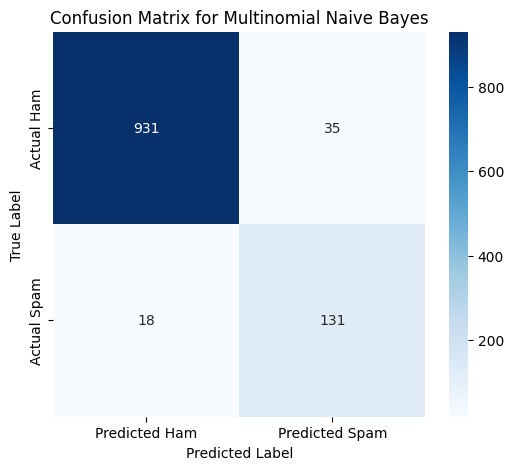


--- Logistic Regression Model Evaluation ---
Accuracy: 0.9785
Precision: 0.9699
Recall: 0.8658
F1-Score: 0.9149

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.97      0.87      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



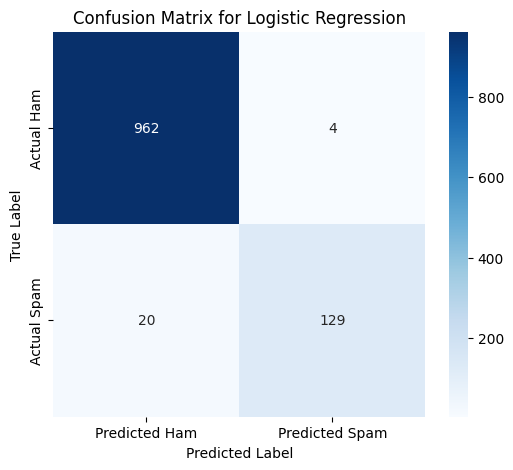


--- Random Forest Classifier Model Evaluation ---
Accuracy: 0.9848
Precision: 1.0000
Recall: 0.8859
F1-Score: 0.9395

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115



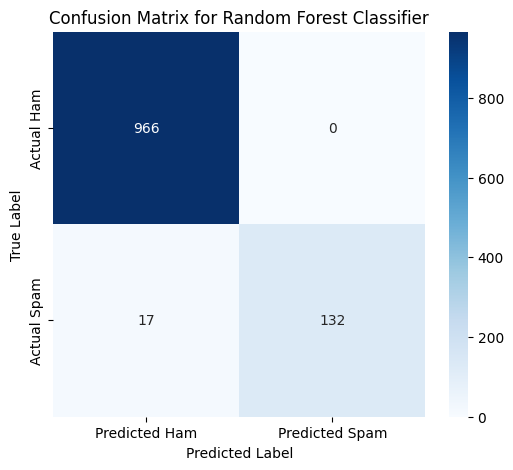


--- Cross-validation Scores (Accuracy) ---
Multinomial Naive Bayes CV Accuracy: 0.9566 (+/- 0.0034)
Logistic Regression CV Accuracy: 0.9790 (+/- 0.0046)
Random Forest Classifier CV Accuracy: 0.9849 (+/- 0.0046)


In [9]:
# --- Model Evaluation ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate and print metrics for a given model
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    print(f"\n--- {model_name} Model Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}") # Important: Minimize false positives (ham classified as spam)
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")     # Important: Maximize detection of actual spam
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Ham', 'Predicted Spam'],
                yticklabels=['Actual Ham', 'Actual Spam'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate each trained model
evaluate_model(mnb_model, X_test, y_test, "Multinomial Naive Bayes")
evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest Classifier")

# You can also run cross-validation for a more robust estimate of performance
# Note: Cross-validation can take a bit longer as it trains the model multiple times
print("\n--- Cross-validation Scores (Accuracy) ---")
cv_scores_mnb = cross_val_score(mnb_model, X_combined, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Multinomial Naive Bayes CV Accuracy: {np.mean(cv_scores_mnb):.4f} (+/- {np.std(cv_scores_mnb):.4f})")

cv_scores_lr = cross_val_score(lr_model, X_combined, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Logistic Regression CV Accuracy: {np.mean(cv_scores_lr):.4f} (+/- {np.std(cv_scores_lr):.4f})")

cv_scores_rf = cross_val_score(rf_model, X_combined, y, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Random Forest Classifier CV Accuracy: {np.mean(cv_scores_rf):.4f} (+/- {np.std(cv_scores_rf):.4f})")


Starting Hyperparameter Tuning for Random Forest Classifier...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Hyperparameter tuning complete!
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1-score on CV: 0.9396

--- Tuned Random Forest Classifier Model Evaluation ---
Accuracy: 0.9848
Precision: 1.0000
Recall: 0.8859
F1-Score: 0.9395

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115



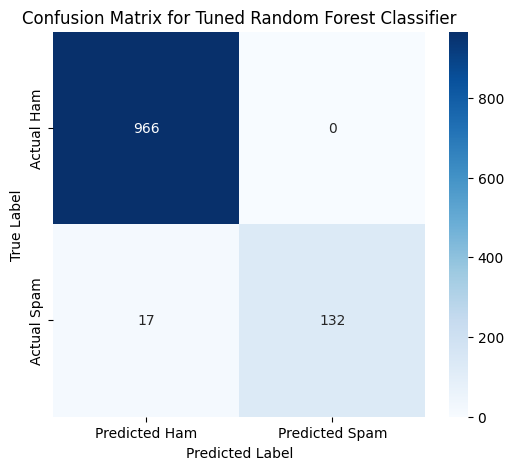


--- Comparison with Untuned Random Forest ---


In [10]:
# --- Hyperparameter Tuning (Random Forest Classifier) ---
from sklearn.model_selection import GridSearchCV

print("\nStarting Hyperparameter Tuning for Random Forest Classifier...")

# Define the parameter grid to search
# These ranges are chosen to be relatively quick for demonstration purposes.
# For a more exhaustive search, you might expand these ranges.
param_grid = {
    'n_estimators': [50, 100, 150], # Number of trees
    'max_features': ['sqrt', 'log2'], # Number of features to consider for best split
    'max_depth': [10, 20, None], # Max depth of trees (None means unlimited)
    'min_samples_leaf': [1, 2], # Minimum number of samples required to be at a leaf node
    'min_samples_split': [2, 5] # Minimum number of samples required to split an internal node
}

# Initialize GridSearchCV
# estimator: The model to tune (RandomForestClassifier)
# param_grid: The dictionary of hyperparameters and their values to try
# cv: Number of folds for cross-validation
# scoring: Metric to optimize (e.g., 'f1' for balanced performance on imbalanced data)
# n_jobs: Number of CPU cores to use (-1 means all available)
# verbose: Controls the verbosity: higher means more messages
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3, # Using 3 folds for faster tuning; 5 is common for final models
                           scoring='f1', # Optimize for F1-score as it balances precision and recall
                           n_jobs=-1,
                           verbose=2)

# Fit GridSearchCV to the training data
# This will train multiple models for each combination in param_grid across CV folds
grid_search.fit(X_train, y_train)

print("\nHyperparameter tuning complete!")

# Print the best parameters found
print(f"Best parameters found: {grid_search.best_params_}")

# Get the best model
best_rf_model = grid_search.best_estimator_
print(f"Best F1-score on CV: {grid_search.best_score_:.4f}")

# Evaluate the best model on the test set
# (Using the evaluate_model function defined in the previous step)
evaluate_model(best_rf_model, X_test, y_test, "Tuned Random Forest Classifier")

# Compare with the untuned Random Forest (from previous evaluation)
print("\n--- Comparison with Untuned Random Forest ---")
# You can manually recall the previous scores for comparison or re-evaluate rf_model
# For simplicity, let's just re-run the evaluation for the untuned one if you want to see them side-by-side
# evaluate_model(rf_model, X_test, y_test, "Untuned Random Forest Classifier") # Uncomment to see again

In [11]:
import joblib

# Save the BEST performing Random Forest model
# Use the best_rf_model obtained from GridSearchCV
joblib.dump(best_rf_model, 'tuned_random_forest_spam_classifier.pkl')
print("Tuned Random Forest model saved.")

# Save the TF-IDF Vectorizer (this is needed for new text inputs)
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
print("TF-IDF Vectorizer saved.")

# Save the list of numerical features' names (this is needed to collect features from new text inputs)
numerical_features_list = ['message_length', 'num_words', 'num_sentences',
                           'num_uppercase_chars', 'num_digits', 'num_punctuation']
joblib.dump(numerical_features_list, 'numerical_features_list.pkl')
print("Numerical features list saved.")

Tuned Random Forest model saved.
TF-IDF Vectorizer saved.
Numerical features list saved.
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_sp